# Epidemics on networks: the SI model
The goal of this assignment will be to implement a working SIS model on a network and reproduce a figure from this week's readings. We will start with an SI model as a template which you can then expand upon to build the SIS model.

I will put together a function that will be able to take as input networkx graphs. In the SI model, a fraction of nodes begin as infected and then new infections spread throughout the network across the links with some probability `beta`. If the dice rolls out of the nodes favor then it becomes infected and can then infect other nodes that it neighbors.

In a connected graph, the SI model should eventually infect everyone as t -> infinity because there will always be a non-zero probability of transmission. Alternatively, the SIS model will reach an equilibrium point where there is a balance between infections and reversions to susceptibility.

Lets walk through building the SI model:

In [168]:
# We will be using numpy and networkx for our function
import networkx as nx
import numpy as np

In [169]:
# There will be 4 parameters for the model:
# (graph) The networkx graph 
# (tmax) The maximum time that we will run the model 
# (beta) The transmission probability 
# (initial_inf) The initial fraction of infected nodes
def SI(graph, tmax, beta, initial_inf):
    
    # First lets generate a set of initially infected nodes.
    # We can do this by having numpy's random choice function pick 
    # nodes from the graph at random without replacement
    # I convert the resulting list to a set so that it 
    # is faster to search over in the next step
    inf_o = set(np.random.choice(graph.nodes(), size=int(len(graph) * initial_inf), replace=False))
    
    # Next we need to create an attribute for the nodes
    # which will designate the state of that node as either infected 
    # or susceptible. We can use networkx's set attribute function to do this.
    
    # There is another issue though. I plan on iterating through each node
    # in order to update its state based on the states of other nodes in the
    # network. If I change the node state, then the next node will
    # be updating with respect to a network that is now in a different state!
    
    # When modelling discrete time systems there are generally two different
    # update strategies used. Synchronous and asynchronous updating. In
    # Asynchronous updating random nodes are picked and their states are 
    # updated according to the current network state.
    # In synchronous updating, there is a global time clock that all
    # nodes are synched to, so nodes only update according to the 
    # state of the network at the current time-step and all nodes
    # are updated simultaneously.
    
    # Choosing the updating scheme can have a huge impact on dynamics.
    # We will be using a synchronous updating scheme, which means we
    # need to store the current state of the system while we update. There are many
    # ways to accomplish this such as having a temporary state dictionary,
    # but because I want to make a time-series graph later, I will just
    # keep the whole network history belonging to each node in a list.
    
    # The code below uses a dictionary comprehension to generate a dictionary
    # with keys=nodes and values=a list of 0's and 1's. The 1 is for infected
    # and 0 is for susceptible. We then give that dictionary to networkx's
    # attribute function which then gives all the nodes the 'inf' attribute.
    
    # I also put a conditional statement in the dictionary comprehension
    # which sets the initial states to 0 or 1 depending upon whether
    # it is in the inf_o set. This all sets up our graph for t=0:
    
    # If you ues networkx 1.9-, this line should be:
#     nx.set_node_attributes(graph,'inf', {node: ([1] if node in inf_o else [0]) for node in graph.nodes()})

    nx.set_node_attributes(graph, {node: ([1] if node in inf_o else [0]) for node in graph.nodes()},'inf')
    
    # Now we need to loop through for each time step
    for t in range(tmax):
        
        # For each time step we need to update all the nodes in the network 
        for node in graph.nodes():
            
            # Now we check if the node if susceptible to infection
            # If it is, we need to determine the probability of it switching
            # and then switch it for the next time-step
            if graph.node[node]['inf'][t] == 0:
                
                # First determine how many infected neighbors the node has at time t:
                num_inf_neighbors = np.sum([ graph.node[neighbor]['inf'][t] for neighbor in graph.neighbors(node)])
                
                # Instead of drawing a bunch of random numbers for each neighbor
                # we  can just calculate the cumulative probability of getting
                # infected since these events are independent and then just
                # draw 1 random number to check against:
                if np.random.random() < (1 - (1 - beta)**num_inf_neighbors):
                    # If infection occurs we add a 1 to the state list of the node.
                    # Note that by doing this we don't change how the other 
                    # nodes update, because they will be using time index t not t+1
                    graph.node[node]['inf'].append(1)
                    
                else:
                    # If no infection occurs, then just append the current state
                    graph.node[node]['inf'].append(graph.node[node]['inf'][t])
                    
            # Similarly, if the node is already infected it can't change back
            # So we append the current state if it wasn't susceptible
            else:
                graph.node[node]['inf'].append(graph.node[node]['inf'][t])
                
    # Once the updates have run their course for all nodes up to tmax we can
    # return the time-series of the fraction of infected nodes
    # It is easy to calculate because I let infected be 1, so the 
    # fraction infected is just the mean of the population at time t:
    return [ np.mean([ graph.node[node]['inf'][t] for node in graph.nodes() ]) for t in range(tmax)]

And there we have our SI model. The function is mostly comments, there are only a dozen lines of code involved in the whole process. Lets give it a run:

In [170]:
# Lets generate a random graph for testing
rnd_graph = nx.erdos_renyi_graph(100, 0.1)

# We want to make sure that the graph is connected, so we will only take the largest
# connected component, as disconnected parts can't be infected or transmit infection:
rnd_graph = max(nx.connected_component_subgraphs(rnd_graph), key=len)

In [171]:
# Now lets plot it
%matplotlib inline
import matplotlib.pyplot as plt

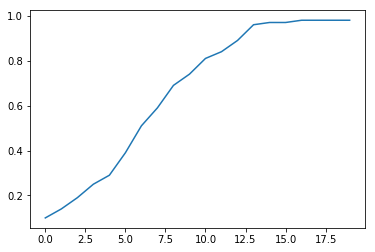

In [172]:
plt.plot(SI(rnd_graph, tmax=20, beta=0.05, initial_inf=0.1))

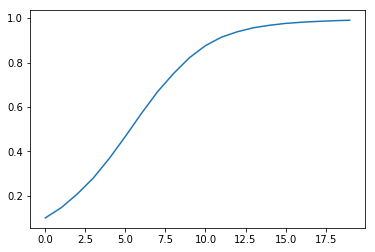

In [173]:
# Since it is a random process we want to do a couple
# sample runs to smooth out the curve

plt.plot( np.mean([SI(rnd_graph, tmax=20, beta=0.05, initial_inf=0.1) for i in range(50)], axis=0) )

The axis argument in `numpy.mean` tells you which axis to apply the average over, since we have a two-dimensional array (time on one axis and trials on the other). If I picked `axis=1` instead, it would have run the average over time rather than the number of trials.

This curve is much smoother than the previous one. You will find that this sort of averaging over trials is necessary when dealing with noisy or random models.

We can see that at 10% initial infected population and an infection rate of 5% we infect the whole 100 node network within 20 time steps. Most of the growth occurs in the middle after the disease ramps up, and then slows as most of the population is already infected.

# Assignment: Building the SIS model
The example SI model should give you a good starting point from which to create the SIS version. In the SIS model, infected nodes can transform back to susceptible nodes, which means you will have one additional parameter that needs to be provided as an argument to the model. Lets call this probability of reversion `mu`. You can either start with the SI function I provided and modify it into the SIS variant, or you can write your own function to taste. 

My implementation is simple but far from optimal, it will be slower to run on larger and more dense graphs. If you want more of a challenge try comming up with an SIS version that can run efficiently on larger graphs. This could be done by relying more heavily on numpy, which uses a c backend for array operations, or using a different network data structure.

Here are your goals:

1. Create an SIS version of the function, either by building off of mine or making your own from scratch.
2. Plot your model's results using a sparse random graph and play with the parameters to get a feel for how `mu`, `beta`, and `initial_inf` change the equilibrium point of the system. The equilibrium point occurs when the system settles on a stable fraction of infected (see Fig 10.7 in Barabasi's textbook). Also take note of how long it takes for the system to reach equilibrium.
3. Finally, construct a graph like Fig 10.11 from Barabasi's book that shows the difference between Erdos-Renyi graphs and Scale-free graphs for the SIS-model. The Y-axis in the figure will be the equilibrium point of the system. This will generally be the last time point of your simulation, assuming you run it long enough to let it reach equilibrium. The X-axis is the parameter `lambda` which is just `beta / mu`. The exact location of the critical point for the SIS model on the ER graph will vary depending upon parameters, but the key take-away is that the Scale-free graph's is lower (and eventually vanishes depending upon scaling exponent). Lastly, remember to use averaging to smooth the curves over many trials for each data-point. Note: The BA algorithm only generates exponents of 3. You can generate a directed scale-free graph with varying power-law exponent using networkx's [`scafe_free_graph`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.directed.scale_free_graph.html?%20scale_free_graph#networkx.generators.directed.scale_free_graph) function. However, it needs to be converted to an undirected graph. You can make a power-law exponent of ~2.5 with the following parameters `alpha=0.35`, `beta=0.60`, `gamma=0.05`, `delta_in=0.4`, `delta_out=0.4`

4. When you are done submit your notebook to Canvas.

In [265]:
# There will be 4 parameters for the model:
# (graph) The networkx graph 
# (tmax) The maximum time that we will run the model 
# (beta) The transmission probability 
# (initial_inf) The initial fraction of infected nodes
def SIS(graph, tmax, beta, initial_inf,mu):
    
    # First lets generate a set of initially infected nodes.
    # We can do this by having numpy's random choice function pick 
    # nodes from the graph at random without replacement
    # I convert the resulting list to a set so that it 
    # is faster to search over in the next step
    inf_o = set(np.random.choice(graph.nodes(), size=int(len(graph) * initial_inf), replace=False))

# SIS model logic
#if node is not infected
#	get neighbors
#	chk if it can be infected
#	if can be infected
#		mark as infected
#	else can not be infected
#		continue state
#else node infected
#	chk if it can be recovered
#	if can be recovered
#		mark as susceptible
#	else can not recover
#		continue state

    nx.set_node_attributes(graph, {node: ([1] if node in inf_o else [0]) for node in graph.nodes()},'inf')
    
    # Now we need to loop through for each time step
    for t in range(tmax):
        
        # For each time step we need to update all the nodes in the network 
        for node in graph.nodes():
            num_inf_neighbors = np.sum([ graph.node[neighbor]['inf'][t] for neighbor in graph.neighbors(node)])
            # Now we check if the node if susceptible to infection
            # If it is, we need to determine the probability of it switching
            # and then switch it for the next time-step
            if graph.node[node]['inf'][t] == 0:
                
                # First determine how many infected neighbors the node has at time t:
                #num_inf_neighbors = np.sum([ graph.node[neighbor]['inf'][t] for neighbor in graph.neighbors(node)])
                
                # Instead of drawing a bunch of random numbers for each neighbor
                # we  can just calculate the cumulative probability of getting
                # infected since these events are independent and then just
                # draw 1 random number to check against:
                if np.random.random() < (1 - (1 - beta -mu)**num_inf_neighbors):
                    # If infection occurs we add a 1 to the state list of the node.
                    # Note that by doing this we don't change how the other 
                    # nodes update, because they will be using time index t not t+1
                    graph.node[node]['inf'].append(1)
                    
                else:
                    # If no infection occurs, then just append the current state
                    graph.node[node]['inf'].append(graph.node[node]['inf'][t])
                    
            # Similarly, if the node is already infected it can't change back
            # So we append the current state if it wasn't susceptible
            else:
                # if the node is infected, in SIS model, there is possibility 
                # that node recovers and becomes susceptible again
                # This depends on recovery rate mu
                # we will check the possibility of node getting recovered
                
                if np.random.random() < (1 - (1 - beta + mu)**num_inf_neighbors):
                    # If infection occurs we add a 1 to the state list of the node.
                    # Note that by doing this we don't change how the other 
                    # nodes update, because they will be using time index t not t+1
                    graph.node[node]['inf'].append(0)
                    
                else:
                    # If no infection occurs, then just append the current state
                    graph.node[node]['inf'].append(graph.node[node]['inf'][t])
                
    # Once the updates have run their course for all nodes up to tmax we can
    # return the time-series of the fraction of infected nodes
    # It is easy to calculate because I let infected be 1, so the 
    # fraction infected is just the mean of the population at time t:
    return [ np.mean([ graph.node[node]['inf'][t] for node in graph.nodes() ]) for t in range(tmax)]

In [175]:
# Lets generate a random graph for testing
rnd_graph_sis = nx.erdos_renyi_graph(100, 0.1)

# We want to make sure that the graph is connected, so we will only take the largest
# connected component, as disconnected parts can't be infected or transmit infection:
rnd_graph_sis = max(nx.connected_component_subgraphs(rnd_graph_sis), key=len)

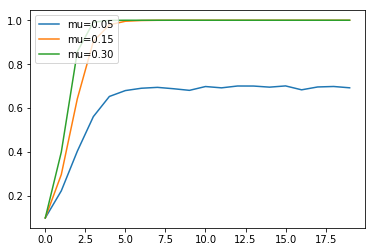

In [266]:
# Since it is a random process we want to do a couple
# sample runs to smooth out the curve

plt.plot( np.mean([SIS(rnd_graph_sis, tmax=20, beta=0.1, initial_inf=0.1, mu=0.05) for i in range(50)], axis=0)  , label = "mu=0.05")
plt.plot( np.mean([SIS(rnd_graph_sis, tmax=20, beta=0.1, initial_inf=0.1, mu=0.15) for i in range(50)], axis=0)  , label = "mu=0.15")
plt.plot( np.mean([SIS(rnd_graph_sis, tmax=20, beta=0.1, initial_inf=0.1, mu=0.3) for i in range(50)], axis=0)  , label = "mu=0.30")
plt.legend(loc='upper left')

In [177]:
sclaefree_graph_sis = nx.scale_free_graph(100,alpha=0.35, beta=0.60, gamma=0.05, delta_in=0.4, delta_out=0.4)

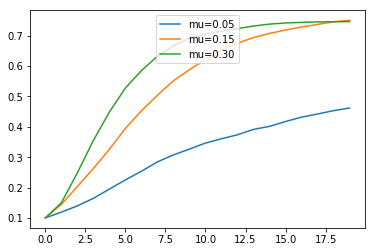

In [267]:
plt.plot( np.mean([SIS(sclaefree_graph_sis, tmax=20, beta=0.1, initial_inf=0.1, mu=0.05) for i in range(50)], axis=0) , label = "mu=0.05")
plt.plot( np.mean([SIS(sclaefree_graph_sis, tmax=20, beta=0.1, initial_inf=0.1, mu=0.15) for i in range(50)], axis=0) , label = "mu=0.15")
plt.plot( np.mean([SIS(sclaefree_graph_sis, tmax=20, beta=0.1, initial_inf=0.1, mu=0.3) for i in range(50)], axis=0) , label = "mu=0.30")
plt.legend(loc='upper center')

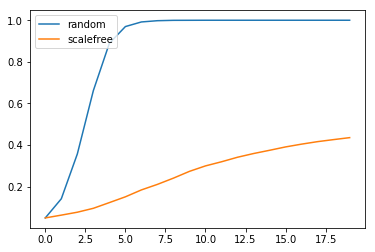

In [268]:
plt.plot( np.mean([SIS(rnd_graph_sis, tmax=20, beta=0.1, initial_inf=0.05, mu=0.1) for i in range(50)], axis=0)  , label = "random")
plt.plot( np.mean([SIS(sclaefree_graph_sis, tmax=20, beta=0.1, initial_inf=0.05, mu=0.1) for i in range(50)], axis=0) , label = "scalefree")
plt.legend(loc='upper left')